<h1 style="text-align: center;"><b>Deep Learning Model for Classifying Snoring and Non-Snoring Sounds</b></h1>
<h4 style="text-align: center;"><i> December 1st, 2024 </i> </h4>
<h4 style="text-align: center;"><i> By Aditya Pendyala </i> </h4>
<p style="text-align: center;">
This project aims to develop a deep learning-based Multilayer Perceptron (MLP) classifier to distinguish snoring from non-snoring audio. By extracting and visualizing features like spectrograms, MFCCs, and waveforms, the model processes these representations to train classifiers for accurate detection.
</p>
<p style="text-align: center;">Find the link to the Github Repository <a href="https://github.com/pendyal1/cmse492_project.git" target="_blank">here!</a></p>


<h4 style="text-align: left;"><b>Project Description:</b></h4>
<p style="text-align: left;">
The objective of this project is to develop a deep learning solution using a Multilayer Perceptron (MLP) to classify audio as either snoring or non-snoring. The model will process `.wav` audio files by extracting key features such as waveform, spectrogram, mel spectrogram, MFCC (Mel-frequency cepstral coefficients), chroma, zero-crossing rate, RMS energy, and STFT (Short-Time Fourier Transform). These features will be visualized as plots, which serve as input for training individual MLP classifiers. 

Potential real-world applications include, but are not limited to, integrating the model into mobile or wearable devices to monitor and track snoring patterns, providing insights for sleep studies, or aiding in the diagnosis and management of sleep disorders such as sleep apnea.
</p>


<h4 style="text-align: left;"><b>About the Dataset:</b></h4>
<a href="https://www.kaggle.com/datasets/tareqkhanemu/snoring" target="_blank">Snoring Dataset on Kaggle</a>
<p style="text-align: left;">
The dataset contains two folders - one for snoring and the other for non-snoring.

Folder 1 contains snoring sounds. It has total 500 sounds. Each sound is 1 second in duration.
Among the 500 snoring samples, 363 samples consist of snoring sounds of children, adult men and adult women without any background sound. The remaining 137 samples consist of snoring sounds having a background of non-snoring sounds.

Folder 0 contains non-snoring sounds. It has total 500 sounds. Each sound is 1 second in duration.
The 500 non-snoring samples consist of background sounds that might be available near the snorer. Ten categories of non-snoring sounds are collected, and each category has 50 samples. The ten categories are baby crying, the clock ticking, the door opened and closed, total silence and the minor sound of the vibration motor of the gadget, toilet flashing, siren of emergency vehicle, rain and thunderstorm, streetcar sounds, people talking, and background television news.
</p>


<h3 style="text-align: center;"><b>Approach 1 - VGG16 based MLP</b></h3>

<h4 style="text-align: left;"><b>Code:</b></h4>

<p style="text-align: left;">
Importing necessary libraries and defining plotting functions.
</p>

In [1]:
import os # for file handling
import librosa # for audio processing
import librosa.display # for audio visualization
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting
from tensorflow.keras.preprocessing.image import ImageDataGenerator # for data augmentation
from tensorflow.keras.models import Sequential # for model creation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # for model layers
from tensorflow.keras.applications import VGG16 # for transfer learning
from tensorflow.keras.applications.vgg16 import preprocess_input # for preprocessing
from sklearn.model_selection import train_test_split # for data splitting
from shutil import copy2 # for file copying
from tensorflow.keras.models import load_model # for model loading
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay # for evaluation
import matplotlib.image as mpimg # for image plotting
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-12-01 07:49:48.395913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Creating helper functions for data extraction

In [2]:
# Function to load and preprocess audio files
def load_and_preprocess_audio(file_path, target_sr=16000): # target_sr is the target sampling rate
    y, sr = librosa.load(file_path, sr=target_sr) # load the audio file
    y = librosa.util.normalize(y) # normalize the audio
    return y, sr # return the audio and the sampling rate


In [3]:
def ensure_dir_exists(directory): # function to create a directory if it does not exist
    if not os.path.exists(directory): # if the directory does not exist
        os.makedirs(directory) # create the directory

# Function to extract the spectrogram
def plot_and_save_feature(y, sr, plot_func, output_dir, class_label, filename, plot_type): # plot_func is the function to plot the feature
    class_dir = os.path.join(output_dir, plot_type, class_label) # create the directory for the class
    ensure_dir_exists(class_dir) # create the directory if it does not exist

    fig, ax = plt.subplots(figsize=(5, 5)) # create a figure
    plot_func(y, sr, ax) # plot the feature
    ax.axis('off') # turn off the axis
    img_path = os.path.join(class_dir, f"{filename}_{plot_type}.png") # create the path to save the image
    plt.savefig(img_path, bbox_inches='tight', pad_inches=0) # save the image
    plt.close() # close the figure


In [4]:
# Defining the plotting functions
def plot_mel_spectrogram(y, sr, ax): # function to plot the mel spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000) # compute the mel spectrogram
    db_mel = librosa.power_to_db(mel_spect, ref=np.max) # convert the power to dB
    img = librosa.display.specshow(db_mel, sr=sr, x_axis='time', y_axis='mel', ax=ax) # plot the mel spectrogram
    ax.set_title("Mel Spectrogram") # set the title of the plot
    plt.colorbar(img, ax=ax, format='%+2.0f dB') # add a colorbar to the plot


<p style="text-align: left;">
Creating helper functions for audio file processing. Furthermore, processing files to create and save plots for each audio file.
</p>

In [5]:
# Function to process and save the plots
def process_and_save_plots(wav_dir, output_dir, class_label): 
    for filename in os.listdir(wav_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(wav_dir, filename)
            y, sr = load_and_preprocess_audio(file_path)
            plot_and_save_feature(y, sr, plot_mel_spectrogram, output_dir, class_label, filename, "mel_spectrogram")


In [6]:
# Directory paths for snoring and non-snoring classes
non_snoring_wav_dir = '/Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/0'
snoring_wav_dir = '/Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/1'
img_base_dir = '/Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/Images/'


In [7]:
# Process and save the plots for the non-snoring class
process_and_save_plots(snoring_wav_dir, img_base_dir, '1')  # '1' for snoring

In [8]:
# Process and save the plots for the snoring class
process_and_save_plots(non_snoring_wav_dir, img_base_dir, '0')  # '0' for non-snoring


Example of mel-spectrograms for a snoring and non-snoring audio file

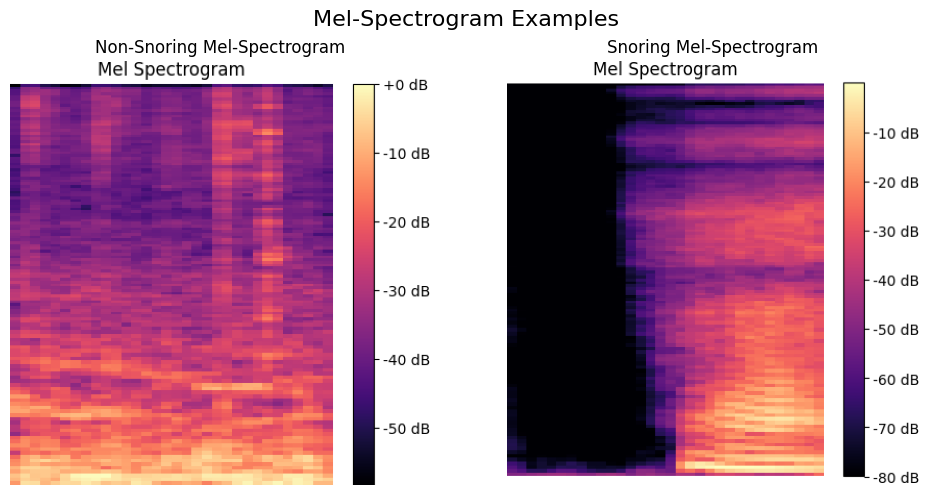

In [7]:
# File paths for one snoring and one non-snoring mel-spectrogram
non_snoring_mel_path = '/Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/Images/mel_spectrogram/0/0_73.wav_mel_spectrogram.png'
snoring_mel_path = '/Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/Images/mel_spectrogram/1/1_73.wav_mel_spectrogram.png'

# Load and display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # Create a figure with 2 subplots

# Non-snoring Mel-spectrogram
non_snoring_img = mpimg.imread(non_snoring_mel_path) # Load the image
axes[0].imshow(non_snoring_img) # Display the image
axes[0].axis('off')  # Hide axes
axes[0].set_title('Non-Snoring Mel-Spectrogram') # Set the title

# Snoring Mel-spectrogram
snoring_img = mpimg.imread(snoring_mel_path) # Load the image
axes[1].imshow(snoring_img) # Display the image
axes[1].axis('off')  # Hide axes
axes[1].set_title('Snoring Mel-Spectrogram') # Set the title

# Adjust layout and display
plt.suptitle('Mel-Spectrogram Examples', fontsize=16) # Set the title for the figure
plt.tight_layout() # Adjust the layout
plt.show() # Display the figure


Preparing Datasets

In [8]:
# Split the data into training and validation sets
plot_types = ['mel_spectrogram'] # list of plot types
train_dir = os.path.join(img_base_dir, 'train') # training directory
val_dir = os.path.join(img_base_dir, 'val') # validation directory

In [9]:
# Function to prepare the dataset
def prepare_dataset(feature_dir, plot_types, train_dir, val_dir, test_split=0.2):  # test_split is the proportion of validation data
    for plot_type in plot_types: # iterate over the plot types
        type_dir = os.path.join(feature_dir, plot_type) # directory for the plot type
        for class_label in ['0', '1']: # iterate over the class labels
            files = os.listdir(os.path.join(type_dir, class_label)) # list of files for the class
            train_files, val_files = train_test_split(files, test_size=test_split) # split the files into training and validation sets
            
            # Copy files into train/validation directories
            for f in train_files: # iterate over the training files
                dest_dir = os.path.join(train_dir, plot_type, class_label) # destination directory
                ensure_dir_exists(dest_dir) # create the directory if it does not exist
                copy2(os.path.join(type_dir, class_label, f), dest_dir) # copy the file to the destination directory
            
            for f in val_files: # iterate over the validation files
                dest_dir = os.path.join(val_dir, plot_type, class_label) # destination directory
                ensure_dir_exists(dest_dir) # create the directory if it does not exist
                copy2(os.path.join(type_dir, class_label, f), dest_dir) # copy the file to the destination directory

prepare_dataset(img_base_dir, plot_types, train_dir, val_dir) # prepare the dataset

In [9]:
# Create data generators
datagen = ImageDataGenerator(rescale=1./255) # create the image data generator

train_generators = {} # dictionary to store the training generators
val_generators = {} # dictionary to store the validation generators

# Create the generators for each plot type
for plot_type in plot_types: # iterate over the plot types
    train_generators[plot_type] = datagen.flow_from_directory( # create the training generator
        os.path.join(train_dir, plot_type), # directory for the training data
        target_size=(224, 224), # target size for the images
        batch_size=32, # batch size
        class_mode='binary' # class mode
    )
    
    val_generators[plot_type] = datagen.flow_from_directory( # create the validation generator
        os.path.join(val_dir, plot_type), # directory for the validation data
        target_size=(224, 224), # target size for the images
        batch_size=32, # batch size
        class_mode='binary' # class mode
    )


Found 979 images belonging to 2 classes.
Found 583 images belonging to 2 classes.


Building Model

In [10]:
# Build the VGG16 model
early_stopping = EarlyStopping( # early stopping callback
    monitor='val_accuracy', # monitor the validation accuracy
    mode='max', # maximize the validation accuracy
    patience=5, # wait for 5 epochs with no improvement
    verbose=1, # log the callback
    min_delta=0.001, # minimum change in accuracy
    baseline=0.95 # baseline accuracy
)

def build_vgg16_model(input_shape): # input_shape is the shape of the input
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape) # load the VGG16 model
    model = Sequential([ # create a Sequential model
        base_model, # add the VGG16 model
        Flatten(), # flatten the output
        Dense(256, activation='relu'), # add a dense layer with 256 units
        Dropout(0.5), # add a dropout layer
        Dense(1, activation='sigmoid') # add a dense layer with 1 unit and a sigmoid activation function
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall']) # compile the model
    return model # return the model

# Define the input shape
input_shape = (224, 224, 3)
model = build_vgg16_model(input_shape) # build the VGG16 model

# Train the model on mel spectrograms
history = model.fit( # train the model
    train_generators['mel_spectrogram'], # training data
    validation_data=val_generators['mel_spectrogram'], # validation data
    epochs=20, # number of epochs
    callbacks=[early_stopping] # early stopping callback
)
model_path = '/Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/Images/mel_spectrogram_vgg16_model.h5'
model.save(model_path) # save the model


Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 322s 10s/step - Precision: 0.4831 - Recall: 0.6468 - accuracy: 0.4739 - loss: 3.3775 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5043 - val_loss: 0.6905
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 350s 11s/step - Precision: 0.5030 - Recall: 0.4505 - accuracy: 0.5102 - loss: 0.6972 - val_Precision: 0.8346 - val_Recall: 0.3841 - val_accuracy: 0.6569 - val_loss: 0.6608
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 387s 12s/step - Precision: 0.7075 - Recall: 0.6826 - accuracy: 0.6892 - loss: 0.6089 - val_Precision: 0.7969 - val_Recall: 0.7197 - val_accuracy: 0.7702 - val_loss: 0.5118
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 351s 11s/step - Precision: 0.7528 - Recall: 0.7063 - accuracy: 0.7405 - loss: 0.5026 - val_Precision: 0.9012 - val_Recall: 0.7578 - val_accuracy: 0.8388 - val_loss: 0.3308
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 311s 10s/step - Precision: 0.8799 - Recall: 0.7599 - accuracy: 0.8313 - loss: 0.3662 - val_Precision: 0.9372 - val_Recall: 0.

Plotting Results

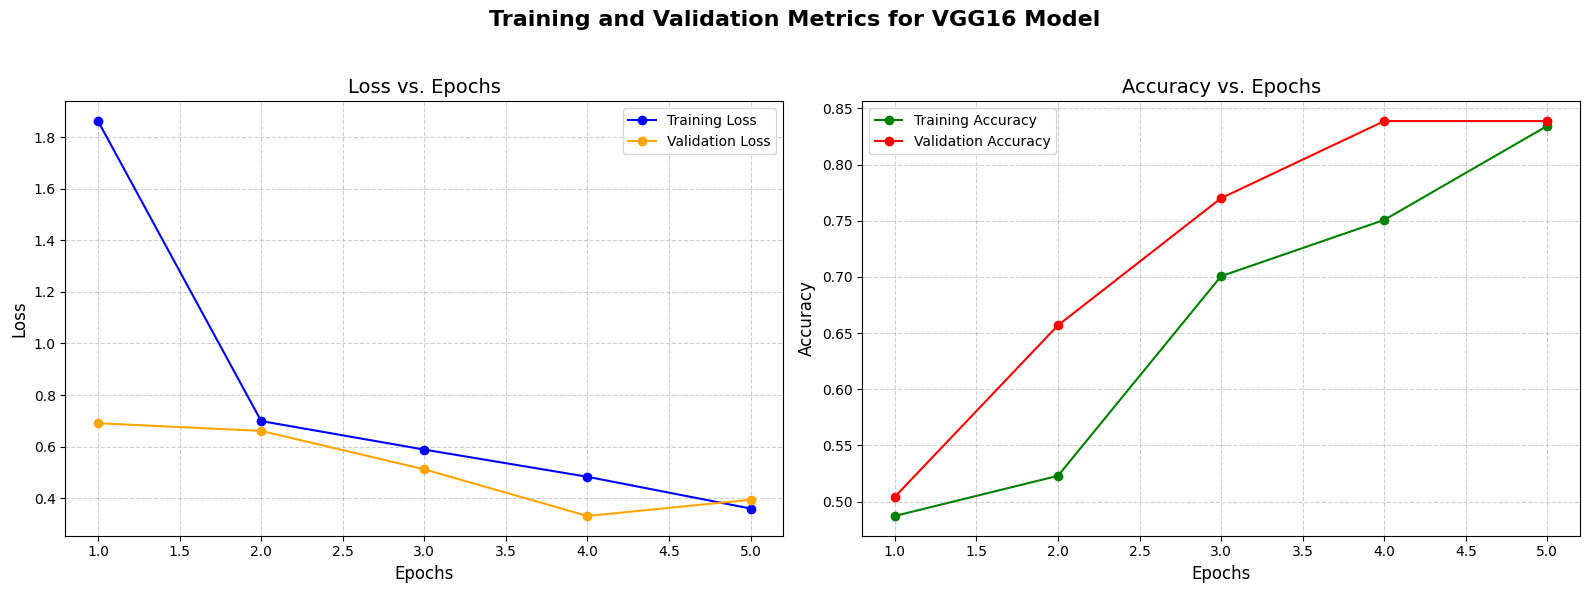

In [11]:
# Plotting the Loss and Accuracy vs. Epochs
def plot_training_history(history): 
    # Extracting training and validation metrics
    epochs = range(1, len(history.history['loss']) + 1) # Number of epochs
    train_loss = history.history['loss'] # Training loss
    val_loss = history.history['val_loss'] # Validation loss
    train_accuracy = history.history['accuracy'] # Training accuracy
    val_accuracy = history.history['val_accuracy'] # Validation accuracy

    # Creating the main figure
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # Two subplots side by side
    fig.suptitle('Training and Validation Metrics for VGG16 Model', fontsize=16, weight='bold') # Main title

    # Plot 1: Loss vs. Epochs
    ax[0].plot(epochs, train_loss, label='Training Loss', color='blue', marker='o') # Training Loss
    ax[0].plot(epochs, val_loss, label='Validation Loss', color='orange', marker='o') # Validation Loss
    ax[0].set_title('Loss vs. Epochs', fontsize=14) # Subplot title
    ax[0].set_xlabel('Epochs', fontsize=12) # X-axis label
    ax[0].set_ylabel('Loss', fontsize=12) # Y-axis label
    ax[0].legend(fontsize=10) # Legend
    ax[0].grid(True, linestyle='--', alpha=0.6) # Add grid

    # Plot 2: Accuracy vs. Epochs
    ax[1].plot(epochs, train_accuracy, label='Training Accuracy', color='green', marker='o') # Training Accuracy
    ax[1].plot(epochs, val_accuracy, label='Validation Accuracy', color='red', marker='o') # Validation Accuracy
    ax[1].set_title('Accuracy vs. Epochs', fontsize=14) # Subplot title
    ax[1].set_xlabel('Epochs', fontsize=12)  # X-axis label
    ax[1].set_ylabel('Accuracy', fontsize=12) # Y-axis label
    ax[1].legend(fontsize=10) # Legend
    ax[1].grid(True, linestyle='--', alpha=0.6) # Add grid

    # Tight layout to adjust spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leaves space for the main title
    plt.show() # Show the plot

# Call the function to plot training history
plot_training_history(history) # Plot the training history


Loaded model from /Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/Images/mel_spectrogram_vgg16_model.h5
Found 583 images belonging to 2 classes.
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step
ROC AUC: 0.982


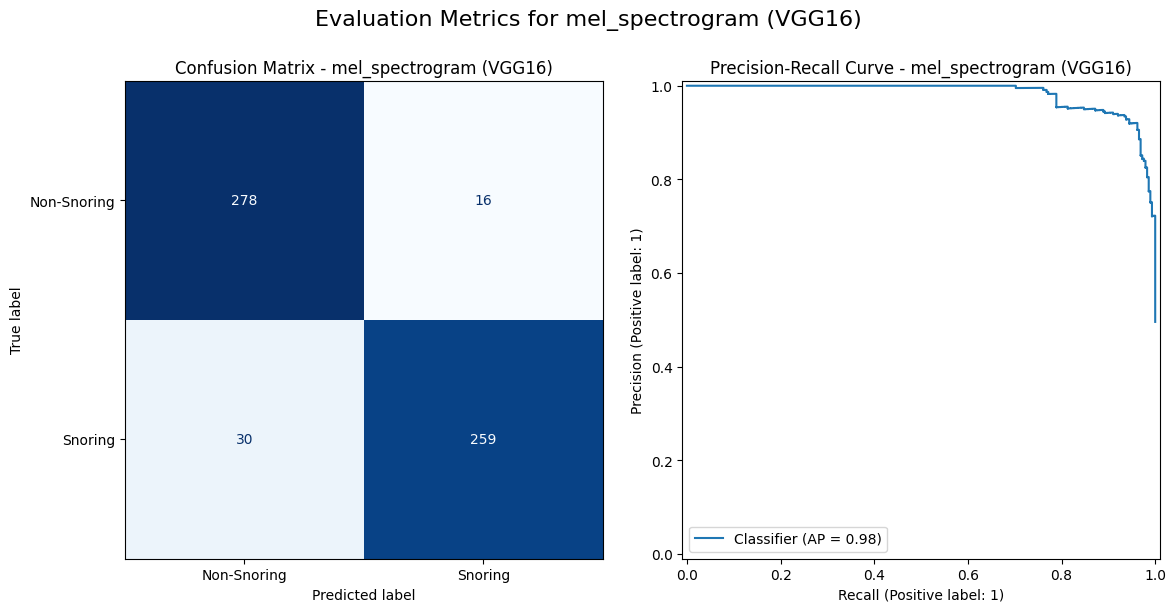

Precision: 0.942
Recall: 0.896


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_score, recall_score

# Load the saved model
model_path = '/Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/Images/mel_spectrogram_vgg16_model.h5'
val_img_dir = '/Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/Images/val/mel_spectrogram'
model = load_model(model_path) # load the model
print(f"Loaded model from {model_path}") # print the path

# Create a generator for the test data
test_datagen = ImageDataGenerator(rescale=1./255) # create the image data generator
test_gen = test_datagen.flow_from_directory( # create the test generator
    val_img_dir, # directory for the test data
    target_size=(224, 224), # target size for the images
    batch_size=32, # batch size
    class_mode='binary', # class mode
    shuffle=False # do not shuffle the data
)

# Predict and evaluate
y_true = test_gen.classes   # True labels
y_pred = model.predict(test_gen).ravel() # Predicted labels

# Compute metrics
auc = roc_auc_score(y_true, y_pred) # ROC AUC
print(f"ROC AUC: {auc:.3f}") # print the ROC AUC

# Confusion Matrix
cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int)) # Confusion Matrix

# Plotting confusion matrix and precision-recall curve
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) # Create a figure with 2 subplots

# Confusion Matrix
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Snoring', 'Snoring']) # create the confusion matrix display
disp_cm.plot(cmap='Blues', ax=axes[0], colorbar=False) # plot the confusion matrix
axes[0].set_title("Confusion Matrix - mel_spectrogram (VGG16)") # set the title

# Precision-Recall Curve
disp_pr = PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=axes[1]) # create the precision-recall display
axes[1].set_title("Precision-Recall Curve - mel_spectrogram (VGG16)") # set the title

# Main plot adjustments
plt.suptitle("Evaluation Metrics for mel_spectrogram (VGG16)", fontsize=16) # set the main title
plt.tight_layout(rect=[0, 0, 1, 0.95]) # adjust the layout
plt.show() # display the plot

# Compute precision and recall
y_pred_binary = (y_pred > 0.5).astype(int) # convert the predicted probabilities to binary
precision = precision_score(y_true, y_pred_binary) # compute the precision
recall = recall_score(y_true, y_pred_binary) # compute the recall

print(f"Precision: {precision:.3f}") # print the precision
print(f"Recall: {recall:.3f}") # print the recall


<h3 style="text-align: center;"><b>Approach 2 - SGD Classifier</b></h3>

In [14]:
import os
import numpy as np
from librosa.feature import mfcc
import librosa
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [15]:
# Directories
non_snoring_wav_dir = '/Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/0'
snoring_wav_dir = '/Users/adi/Documents/Fall 2024/CMSE 492/Project/data/Snoring Dataset/1'

# Function to extract MFCC features from a .wav file
def extract_features(file_path, n_mfcc=13): # n_mfcc is the number of MFCCs to extract
    try: # try to extract the features
        y, sr = librosa.load(file_path, sr=None)  # Load audio file
        features = mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Compute MFCCs
        return np.mean(features.T, axis=0)  # Average over time
    except Exception as e: # if an error occurs
        print(f"Error processing {file_path}: {e}") # Print error message
        return None # Return None


In [16]:
# Load data and labels
file_paths = [] # list to store file paths
labels = [] # list to store labels

# Load non-snoring files
for i in range(1, 490): # iterate over the non-snoring files
    file_paths.append(os.path.join(non_snoring_wav_dir, f"0_{i}.wav")) # add the file path
    labels.append(0)  # Non-snoring label 

# Load snoring files
for i in range(1, 490): # iterate over the snoring files
    file_paths.append(os.path.join(snoring_wav_dir, f"1_{i}.wav")) # add the file path
    labels.append(1)  # Snoring label

In [17]:
# Extract features for all files
print("Extracting features from audio files...") # Print message
X = [] # list to store features
y = [] # list to store labels
for file, label in zip(file_paths, labels): # iterate over the files and labels
    features = extract_features(file) # extract features
    if features is not None:  # Skip files with errors
        X.append(features) # Append features
        y.append(label) # Append label

X = np.array(X) # Convert to numpy arrays
y = np.array(y) # Convert to numpy arrays

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split the data


Extracting features from audio files...


In [18]:
# Train SGD classifier
print("Training SGD classifier...") # Print message
sgd_clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)  # Create the classifier
sgd_clf.fit(X_train, y_train) # Fit the model


# Evaluate the model
y_pred = sgd_clf.predict(X_test) # Predict the test data
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}") # Print the accuracy
print("Classification Report:") # Print the classification report
print(classification_report(y_test, y_pred)) # Print the classification report

Training SGD classifier...
Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.52      0.61        95
           1       0.65      0.83      0.73       101

    accuracy                           0.68       196
   macro avg       0.69      0.67      0.67       196
weighted avg       0.69      0.68      0.67       196



Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.52      0.61        95
           1       0.65      0.83      0.73       101

    accuracy                           0.68       196
   macro avg       0.69      0.67      0.67       196
weighted avg       0.69      0.68      0.67       196

ROC AUC: 0.671


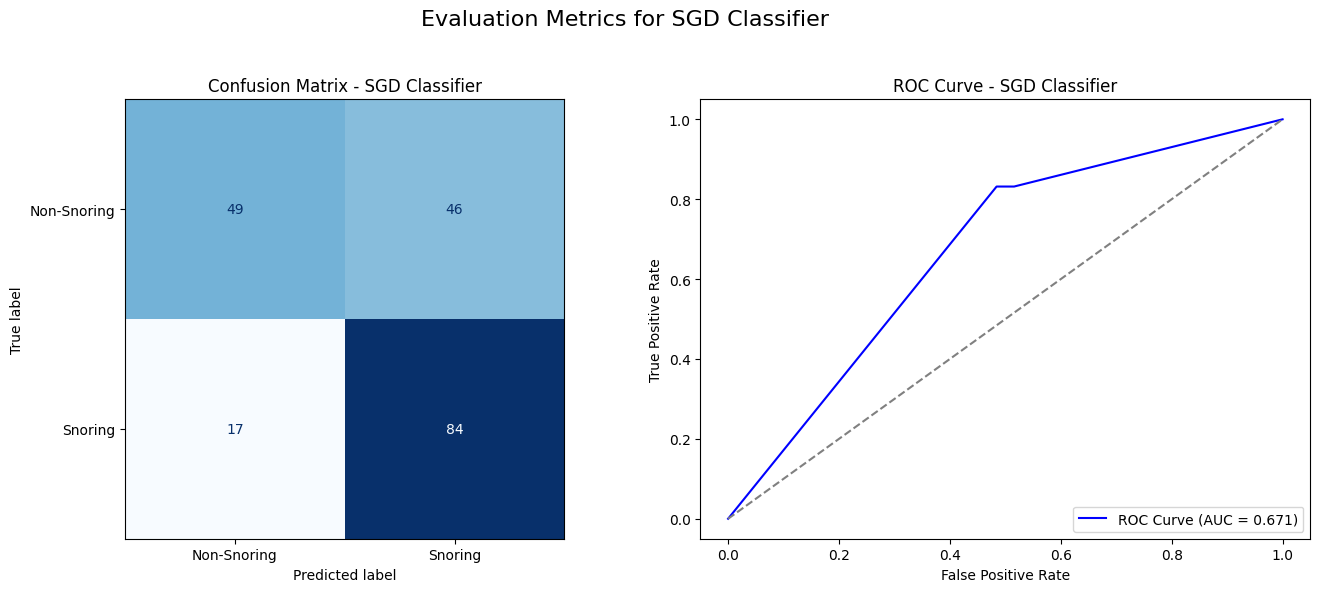

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, accuracy_score, classification_report, roc_auc_score, roc_curve

# Evaluate the model
y_pred = sgd_clf.predict(X_test) # Predict the test data

# Compute metrics
accuracy = accuracy_score(y_test, y_pred) # Accuracy
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred) # Confusion Matrix

# ROC-AUC Score (Optional, useful for binary classification)
y_prob = sgd_clf.predict_proba(X_test)[:, 1]  # Get the probability for the positive class (snoring)
auc = roc_auc_score(y_test, y_prob) # Compute ROC AUC
print(f"ROC AUC: {auc:.3f}")

# Create subplots for Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Create a figure with 2 subplots

# Confusion Matrix
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Snoring', 'Snoring']) # Create the confusion matrix display
disp_cm.plot(cmap='Blues', ax=axes[0], colorbar=False) # Plot the confusion matrix
axes[0].set_title("Confusion Matrix - SGD Classifier") # Set the title

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Compute ROC curve
axes[1].plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.3f})') # Plot ROC curve
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
axes[1].set_xlabel('False Positive Rate') # X-axis label
axes[1].set_ylabel('True Positive Rate') # Y-axis label
axes[1].set_title('ROC Curve - SGD Classifier') # Set the title
axes[1].legend(loc='lower right') # Add legend

# Main title for the entire figure
plt.suptitle("Evaluation Metrics for SGD Classifier", fontsize=16) # Set the main title

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust to avoid overlap with main title 
plt.show() # Show the plot


<h4 style="text-align: left;"><b>References:</b></h4>

T. H. Khan, "A deep learning model for snoring detection and vibration notification using a smart wearable gadget," Electronics, vol. 8, no. 9, article. 987, ISSN 2079-9292, 2019.